# Rain Prediction
Dataset Resource : [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)
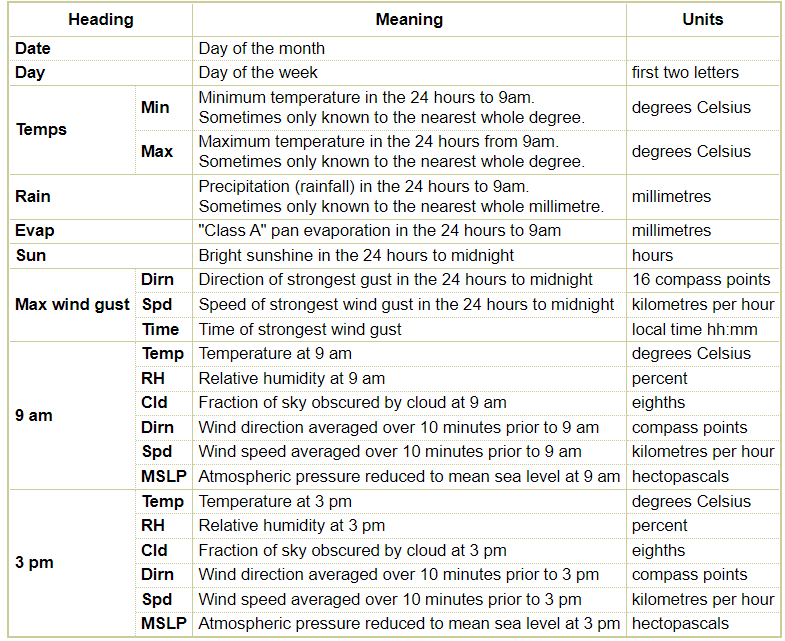

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import missingno as msno

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

# sns.set(style='darkgrid')
# %matplotlib inline

In [ ]:
data = pd.read_csv('../input/weather-dataset-rattle-package/weatherAUS.csv')
df=data.copy()
df.head()

In [ ]:
df.shape

In [ ]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)
null_values(df)

In [ ]:
# import missingno as msno
# msno.matrix(df);

In [ ]:
# msno.bar(df);

In [ ]:
# msno.heatmap(df);

In [ ]:
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
df[['RainToday', 'RainTomorrow']].isnull().sum()

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))

summary(df)

In [ ]:
df[['RainToday','RainTomorrow']] = df[['RainToday','RainTomorrow']].replace({'Yes':1, 'No':0})

In [ ]:
df = df.dropna()

### Make Feature Engineering

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df['Year'] = df['Date'].dt.year.astype('int16')
df['Month'] = df['Date'].dt.month.astype('int16')
df['Year_Month']=df['Date'].array.strftime('%Y-%m') # strftime works with array
df['DiffTemp']=df['MaxTemp']-df['MinTemp']
df.head()

In [ ]:
# for all variables 
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True, cmap="coolwarm");

In [ ]:
plt.figure(figsize=(10,6))
df.corr()["RainTomorrow"].sort_values().plot.barh();

We drop all but one of the features that are highly correlated with each other.

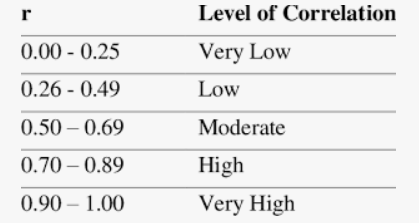

In [ ]:
def corrank(X, threshold=0):
    import itertools
    df = pd.DataFrame([[i,j,X.corr().abs().loc[i,j]] for i,j in list(itertools.combinations(X.corr().abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

# prints a descending list of correlation pair (Max on top)
corrank(df, 0.7)

In [ ]:
# df.groupby('Location')['RainTomorrow','RainToday'].agg(['mean'])

In [ ]:
drop_list=[
            'Date', 
#             'Location', 
#             'MinTemp', 
#            'MaxTemp', 'Rainfall', 
#            'Evaporation',
#            'Sunshine', 
#            'WindGustDir', 
#            'WindGustSpeed', 
#            'WindDir9am', 'WindDir3pm',
#            'WindSpeed9am', 'WindSpeed3pm', 
#            'Humidity9am',
#            'Humidity3pm',
#            'Pressure9am', 
#            'Pressure3pm', 
#            'Cloud9am', 
#            'Cloud3pm', 
#            'Temp9am','Temp3pm', 
#            'RainToday', 
#            'RainTomorrow', 
           'Year', 'Year_Month',
#             'Month',
#        'DiffTemp',
          ]

In [ ]:
df = df.drop(drop_list, axis=1)

In [ ]:
df.isnull().any().sum()

## Outliers

### Isolation Forest
Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.
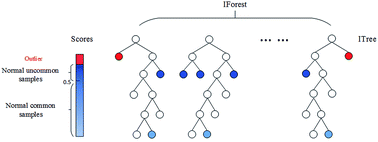

In [ ]:
df.columns

In [ ]:
df = pd.get_dummies(df, drop_first=True, columns = ['Location','WindGustDir','WindDir9am','WindDir3pm'])

In [ ]:
summary(df)

while 'RainTomorrow' is the target label, others are the independent features

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

df_isolation_forest = df.copy()

y_iso = df_isolation_forest['RainTomorrow']
X_iso = df_isolation_forest.drop(['RainTomorrow'], axis=1)

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.10, random_state=42)
clf.fit(X_iso)

In [ ]:
outliers_values = X_iso[clf.predict(X_iso) == -1]
f"{len(outliers_values)} rows are outliers"

In [ ]:
df_noOutlier = X_iso.join(y_iso)[clf.predict(X_iso) == 1]
df_noOutlier

In [ ]:
summary(df_noOutlier)

In [ ]:
df_noOutlier = df_noOutlier.reset_index().drop(['index'], axis=1)

In [ ]:
df_noOutlier.to_csv('weather_cleandata.csv')

## Modelling

In [ ]:
df=pd.read_csv('weather_cleandata.csv',index_col=[0])
df.head()

In [ ]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
# rcParams['figure.figsize'] = 4,4
# plt.style.use('fivethirtyeight')

from collections import Counter

# for modeling 
import sklearn
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [ ]:
# separating the dependent and independent data
X=df.drop(["RainTomorrow"], axis=1)
y=df["RainTomorrow"]

# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

# getting the shapes
print(f"""shape of X_train: {X_train.shape}
shape of X_test\t: {X_test.shape}
shape of y_train: {y_train.shape}
shape of y_test\t: {y_test.shape}""")

### Smooting

In [ ]:
ax = df['RainTomorrow'].value_counts(normalize=True).plot.bar(color=["blue", "red"])
def labels(ax):
    for p in ax.patches:
        ax.annotate(f"%{p.get_height()*100:.2f}", (p.get_x() + 0.15, p.get_height() * 1.005),size=11)
labels(ax)

In [ ]:
# # pip install imblearn
# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import SMOTE

In [ ]:
# oversmote = SMOTE()
# X_train, y_train= oversmote.fit_resample(X_train, y_train)

In [ ]:
# ax = y_train.value_counts().plot.bar(color=["blue", "red"])
# def labels(ax):
#     for p in ax.patches:
#         ax.annotate(f"{p.get_height()}", (p.get_x() + 0.15, p.get_height()+200),size=8)
# labels(ax)
# plt.show()

In [ ]:
# X_train.shape

### Data Scaling

In [ ]:
# creating a minmax scaler
sc = MinMaxScaler()

# fitting independent data to the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
cv_acc_train = {}
cv_acc_test = {}
cv_TPR = {}
cv_FPR = {}
cv_AUC = {}

In [ ]:
def plot_result(model, name:str):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')  
    cv_acc_train[name] = round(scores_train.mean(), 4)*100  # balanced accuracy
    cv_acc_test[name] = round(scores_test.mean(), 4)*100  # balanced accuracy
    cv_TPR[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (Max)
    cv_FPR[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (Min)
    
    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

### 1-Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [ ]:
# lr = LogisticRegression()
# plot_result(lr, "lr")

### 2-Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()
plot_result(nb, "nb")

### 3-K-Nearest Neighbor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# knn = KNeighborsClassifier()
# plot_result(knn, "knn")

### 4-Support Vector Mechanism (SVM)

In [ ]:
# svc = SVC(probability=True)  # default values
# plot_result(svc, "svc")

### 5-Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
dtc = DecisionTreeClassifier()
plot_result(dtc, "dtc")

### 6-NearestCentroid

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
nc = NearestCentroid()
plot_result(nc, "nc")

### 7-Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()
plot_result(rfc, "rfc")

In [ ]:
def plot_feature_importances(model):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:10]

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

    print(f"Top 10 Feature Importance for {str(model).split('(')[0]}\n\n",feature_imp[:10],sep='')

In [ ]:
plot_feature_importances(rfc)

### 8-Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# gbc = GradientBoostingClassifier(random_state=42)
# plot_result(gbc, "gbc")

In [ ]:
# plot_feature_importances(gbc)

### 9-XGBOOST

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [ ]:
xgb = XGBClassifier(eval_metric = "logloss")
plot_result(xgb, "xgb")

In [ ]:
plot_feature_importances(xgb)

### 10-LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
lgb = lgb.LGBMClassifier()
plot_result(lgb, "lgb")

In [ ]:
plot_feature_importances(lgb)

In [ ]:

def AUC(cv_AUC, X_test=X_test):
    dtc_auc= roc_auc_score(y_test,dtc.predict(X_test)) #Decision Tree Classifier
#     lr_auc= roc_auc_score(y_test, lr.decision_function(X_test))#logistic regression
#     svc_auc= roc_auc_score(y_test, svc.decision_function(X_test))#Support Vector Classifier
    nc_auc= roc_auc_score(y_test, nc.predict(X_test))#Nearest Centroid Classifier
    rfc_auc= roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])#Randomforest Classifier
#     gbc_auc= roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])#GradientBoosting Classifier
    nb_auc= roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])#Naive Bayes Classifier
#     knn_auc= roc_auc_score(y_test, knn.predict(X_test))#KNeighbors Classifier
    xgb_auc= roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])#XGBoost Classifier
    lgb_auc= roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])#LightGBM Classifier

    cv_AUC={'dtc': dtc_auc,
#            'lr': lr_auc,
#            'svc':svc_auc,
           'nc':nc_auc,
           'rfc':rfc_auc,
#            'gbc':gbc_auc,
           'nb':nb_auc,
#            'knn':knn_auc,
           'xgb':xgb_auc,
           'lgb':lgb_auc}
    
    return cv_AUC

In [ ]:
cv_AUC = AUC(cv_AUC)
df_eval = pd.DataFrame(data={'model': list(cv_acc_test.keys()), 
                             'bal_acc_train':list(cv_acc_train.values()),
                             'bal_acc_test': list(cv_acc_test.values()), 
                             'recall': list(cv_TPR.values()), 
                             'fallout':list(cv_FPR.values()),
                              'AUC': list(cv_AUC.values())}).round(2)
df_eval

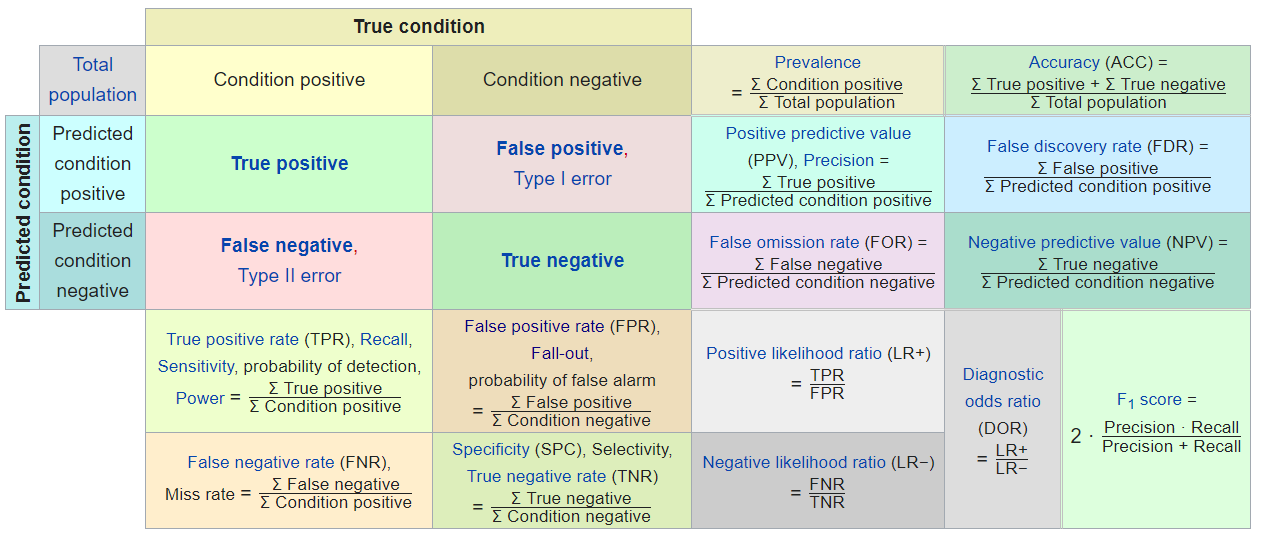

In [ ]:
sns.relplot(x="recall", y="AUC", hue="model", size="bal_acc_test", 
            sizes=(40, 400), alpha=1, palette="bright", height=5, legend='full', data=df_eval);

> **Most succesful model is `Nearest Centroid Classifier`**